In [1]:
from data import prices_NYSE, volume_NYSE, returns_NYSE
from data import prices_SIC, volume_SIC, returns_SIC, benchmark_SIC
from data import expected_return, total_return, daily_return, results_rebalance

from functions import OptimizePortfolioWeights, optimize_lmda, random_portfolio_testing
from backtesting import backtesting

from visualizations import plot_prices, plot_volume, plot_pie, plot_backtesting, plot_simulation_hist, plot_boxplot
from visualizations import plot_efficient_frontier

import optuna
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

## Plotting Volume in Different Markets

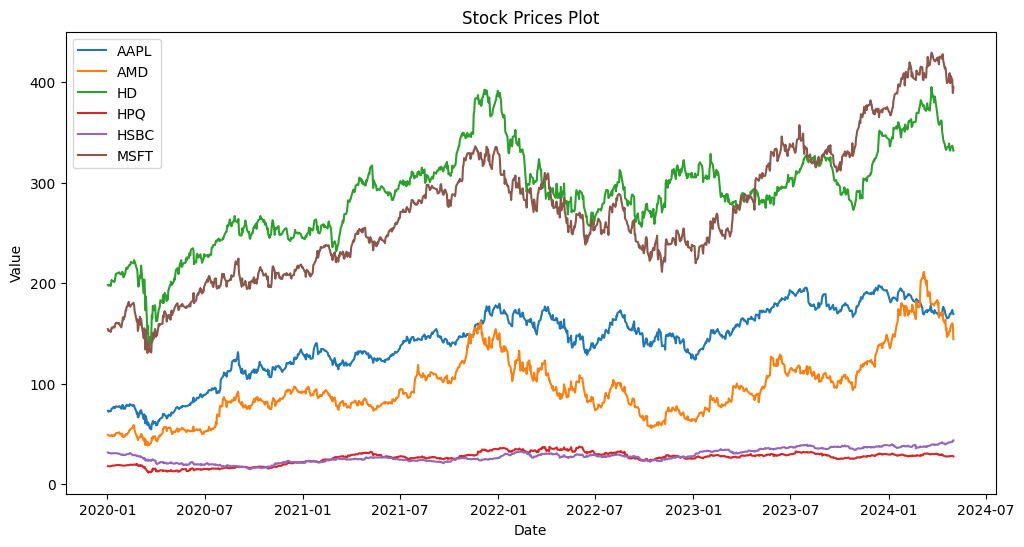

In [2]:
plot_prices(prices_NYSE)

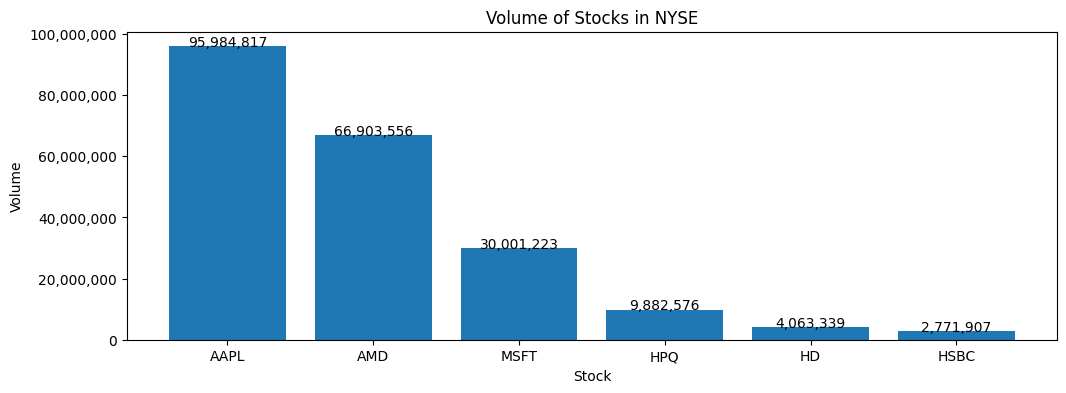

In [3]:
plot_volume(volume_NYSE.mean())

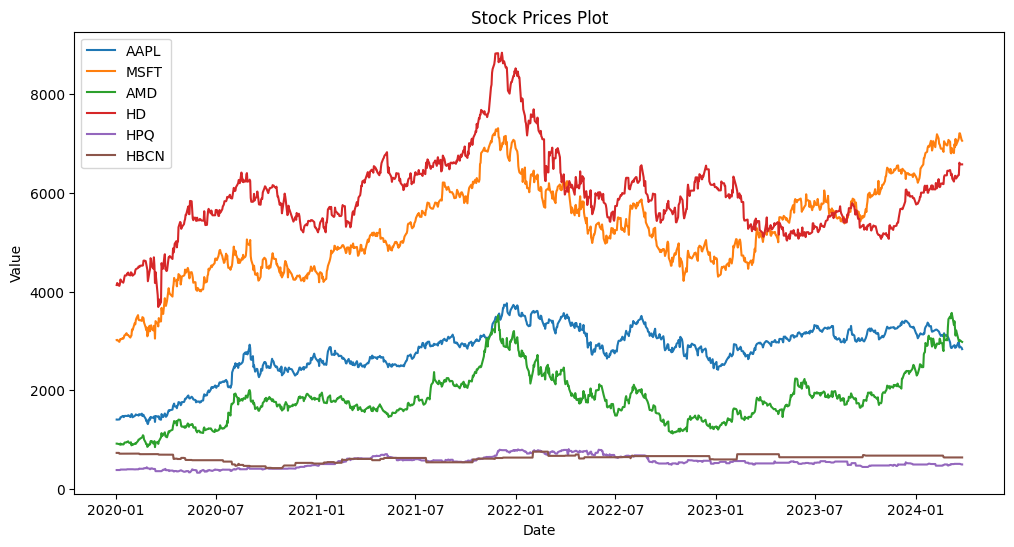

In [4]:
plot_prices(prices_SIC)

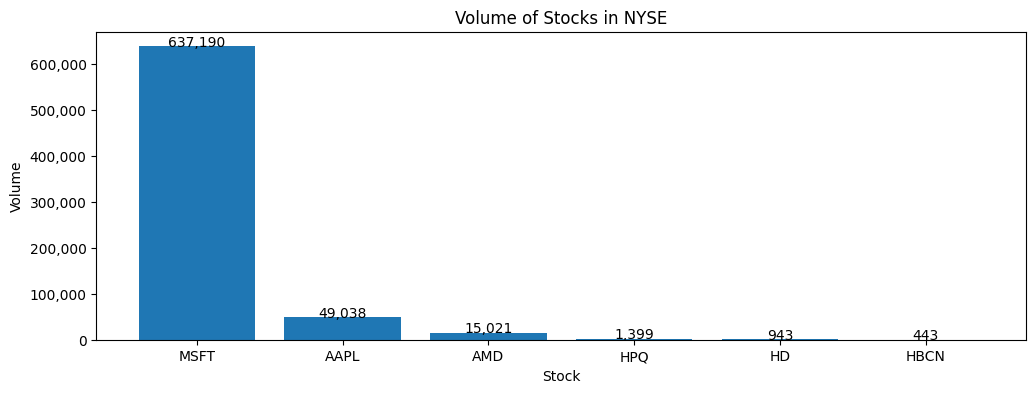

In [5]:
plot_volume(volume_SIC.mean())

## Kernel 1: Covariance 

In [6]:
capital, rf =1000000, 5.5/100

In [7]:
optuna.logging.disable_default_handler()
study_cov = optuna.create_study(direction="minimize")
study_cov.optimize(lambda trial: optimize_lmda(trial, prices_SIC, benchmark_SIC, volume_SIC.mean(), returns_SIC.cov(), capital, rf), n_trials=200)

In [8]:
study_cov.best_params, study_cov.best_value, study_cov.best_trial.user_attrs["weights"]

({'lam': 0.020455491855558595},
 -2920826.933729502,
 array([2.43246483e-02, 5.67804912e-01, 4.07870440e-01, 0.00000000e+00,
        0.00000000e+00, 6.80878964e-17]))

In [9]:
optimizer_1 = OptimizePortfolioWeights(returns=returns_SIC, kernel=returns_SIC.cov(), risk_free=rf)

In [10]:
w_1_covariance, _ = optimizer_1.sharpe_scipy()

w_1_covariance

array([0.01031001, 0.48052115, 0.34957633, 0.03344033, 0.12615218,
       0.        ])

In [11]:
w_2_covariance = study_cov.best_trial.user_attrs["weights"]

w_2_covariance

array([2.43246483e-02, 5.67804912e-01, 4.07870440e-01, 0.00000000e+00,
       0.00000000e+00, 6.80878964e-17])

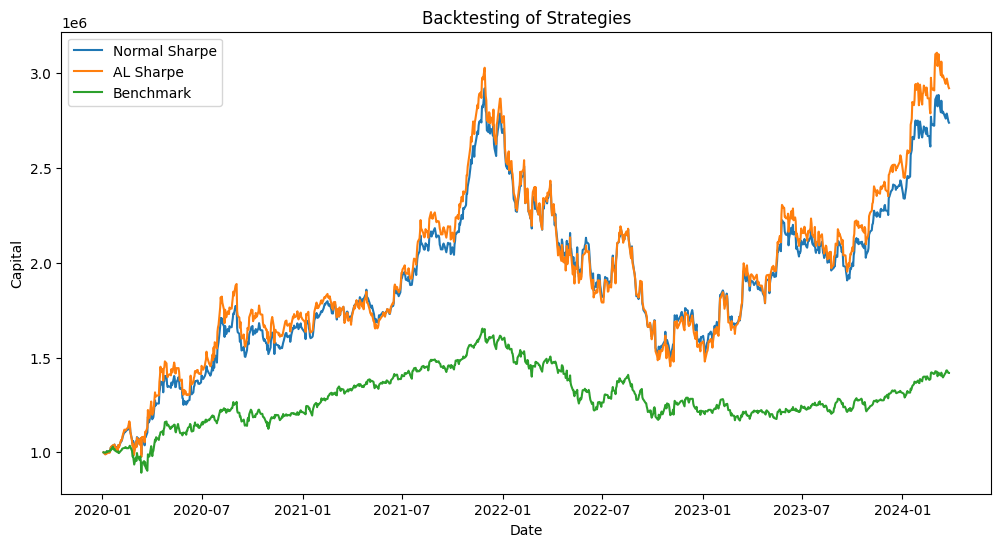

In [12]:
bt=backtesting(weights_summary=[w_1_covariance, w_2_covariance], 
               names=['Normal Sharpe', 'AL Sharpe'], 
               data_stocks=prices_SIC, data_benchmark=benchmark_SIC, cap_inicial=capital)

history=bt.history()

plot_backtesting(history)

In [13]:
bt.metrics(rf=5.5/100)

,Expected Return,Volatility,Sharpe,Downside,Upside,Omega,VaR 97.5%
Normal Sharpe,28.1494,29.3753,0.7710,1.0349,1.1837,1.1437,-3.3812
AL Sharpe,30.9064,33.3401,0.7620,1.1721,1.3525,1.1539,-3.9069


## Kernel 2:  Correlation 

In [14]:
study_corr = optuna.create_study(direction="minimize")
study_corr.optimize(lambda trial: optimize_lmda(trial, prices_SIC, benchmark_SIC, volume_SIC.mean(), returns_SIC.corr(), capital, rf), n_trials=200)

In [15]:
study_corr.best_params, study_corr.best_value, study_corr.best_trial.user_attrs["weights"]

({'lam': 0.010193228148647905},
 -2865490.3952009054,
 array([2.68831388e-01, 3.05135158e-01, 4.26033454e-01, 1.66533454e-16,
        0.00000000e+00, 0.00000000e+00]))

In [16]:
w_corr = study_corr.best_trial.user_attrs["weights"]

w_corr

array([2.68831388e-01, 3.05135158e-01, 4.26033454e-01, 1.66533454e-16,
       0.00000000e+00, 0.00000000e+00])

## Kernel 3: Trying Different Kernels

In [17]:
from functions import try_kernels

In [18]:
import numpy as np
import pandas as pd
import time


standarized_prices=pd.DataFrame(prices_SIC.values/np.max(prices_SIC.values, axis=0))

typ, best_kernel = try_kernels(standarized_prices, benchmark_SIC, volume_SIC.mean(), capital, rf)

In [19]:
typ, best_kernel

('ornstein_kernel_prices',
 [{'l': 4239.8920212274625, 'lam': 39.91466811316238},
  -2333100.8175713373,
  array([0.00000000e+00, 1.00000000e+00, 3.97221922e-10, 0.00000000e+00,
         0.00000000e+00, 4.65952721e-10])])

In [20]:
from functions import ornstein_kernel

ornstein=ornstein_kernel(standarized_prices.T.values, l=best_kernel[0].get('l'))

pd.DataFrame(ornstein)

,0,1,2,3,4,5
0,1.0000,0.9842,0.9440,0.9727,0.9730,0.9711
1,0.9842,1.0000,0.9498,0.9800,0.9727,0.9657
2,0.9440,0.9498,1.0000,0.9581,0.9540,0.9241
3,0.9727,0.9800,0.9581,1.0000,0.9794,0.9560
4,0.9730,0.9727,0.9540,0.9794,1.0000,0.9584
5,0.9711,0.9657,0.9241,0.9560,0.9584,1.0000


In [21]:
ornstein_weights=best_kernel[2]
ornstein_weights

array([0.00000000e+00, 1.00000000e+00, 3.97221922e-10, 0.00000000e+00,
       0.00000000e+00, 4.65952721e-10])

## Comparing all the strategies

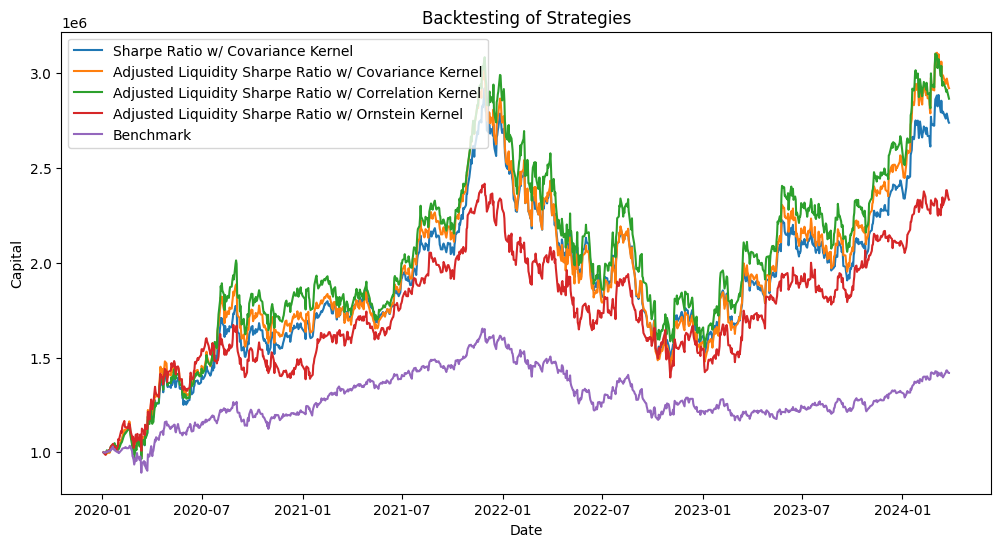

In [22]:
bt=backtesting(weights_summary=[w_1_covariance, w_2_covariance, w_corr, ornstein_weights], 
               names=['Sharpe Ratio w/ Covariance Kernel',
                      'Adjusted Liquidity Sharpe Ratio w/ Covariance Kernel', 
                      'Adjusted Liquidity Sharpe Ratio w/ Correlation Kernel',
                      'Adjusted Liquidity Sharpe Ratio w/ Ornstein Kernel'], 
               data_stocks=prices_SIC, data_benchmark=benchmark_SIC, cap_inicial=capital)


history=bt.history()

plot_backtesting(history)

In [23]:
bt.metrics(rf=5.5/100)

,Expected Return,Volatility,Sharpe,Downside,Upside,Omega,VaR 97.5%
Sharpe Ratio w/ Covariance Kernel,28.1494,29.3753,0.7710,1.0349,1.1837,1.1437,-3.3812
Adjusted Liquidity Sharpe Ratio w/ Covariance Kernel,30.9064,33.3401,0.7620,1.1721,1.3525,1.1539,-3.9069
Adjusted Liquidity Sharpe Ratio w/ Correlation Kernel,30.4106,33.2017,0.7503,1.1733,1.3380,1.1403,-3.9582
Adjusted Liquidity Sharpe Ratio w/ Ornstein Kernel,24.3115,29.2866,0.6423,1.0193,1.2190,1.1958,-3.4987


**Best Strategy: Adjusted by Liquidity Sharpe Ratio with Covariance Kernel**

## Adjusted by Liquidity Sharpe Ratio in the Efficient Frontier

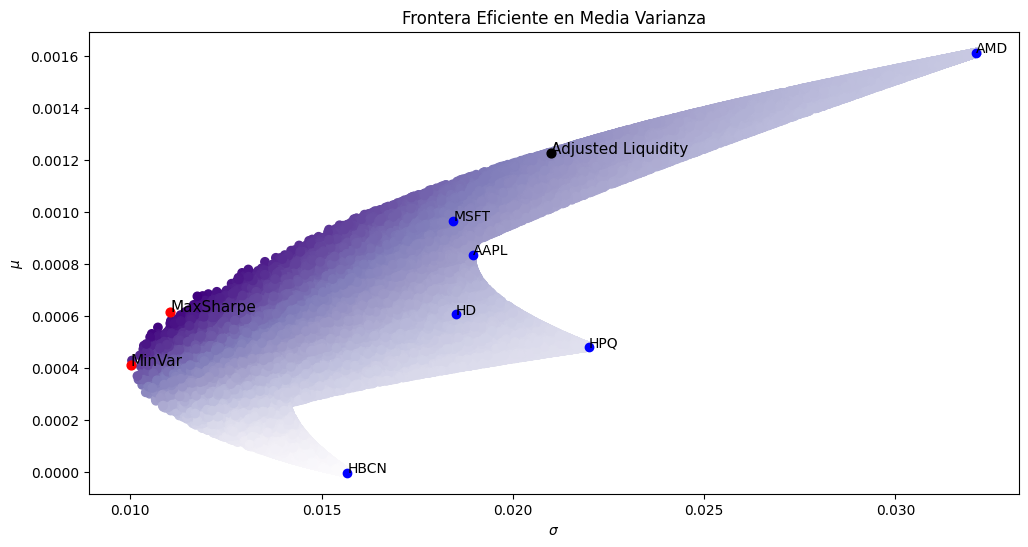

In [24]:
plot_efficient_frontier(returns_SIC, rf, w_2_covariance)

## Simulation of Random Portfolios Summary

### Non-Dynamic Portfolios

In [25]:
sum(expected_return['Adjusted by Liquidity']> expected_return['Sharpe Ratio'])/len(expected_return)*100

69.08999999999999

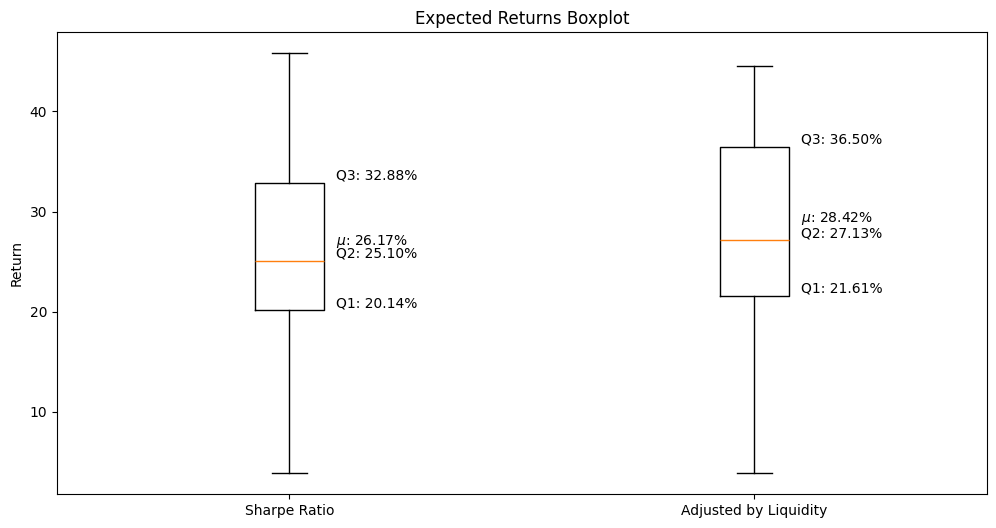

In [26]:
plot_boxplot(expected_return)

### Dynamic Portfolios

In [27]:
sum(results_rebalance['Adjusted by Liquidity']>results_rebalance['Sharpe Ratio'])/len(results_rebalance)*100

64.0

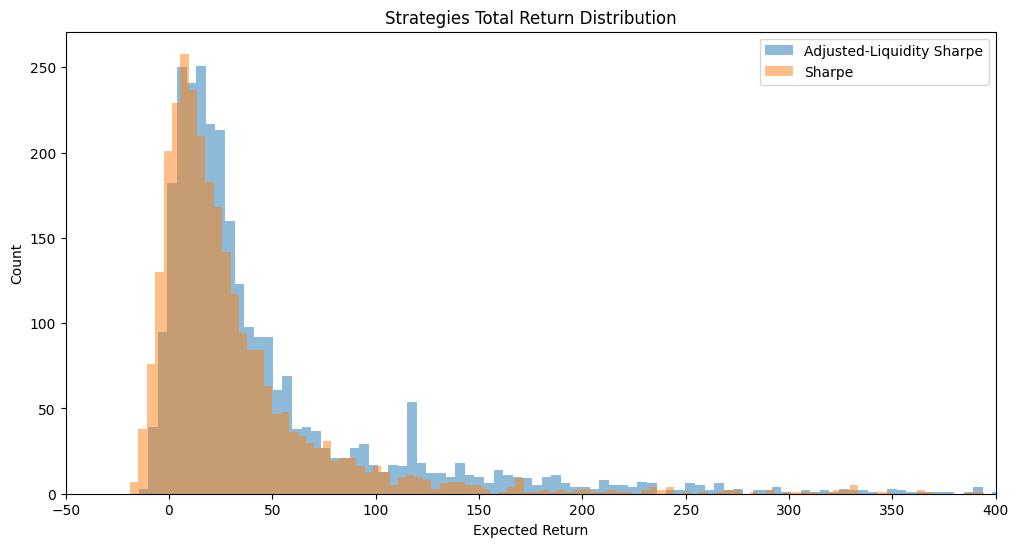

In [28]:
plot_simulation_hist(results_rebalance*100)

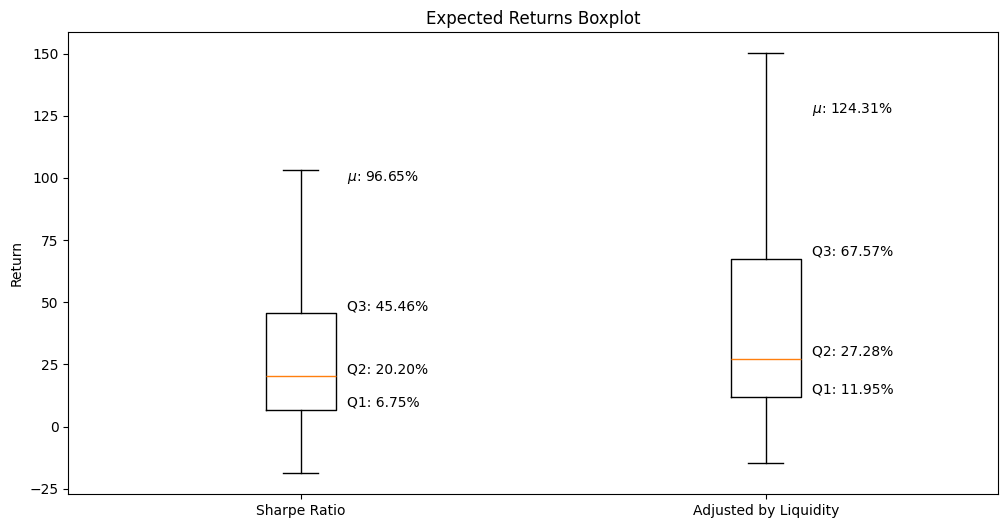

In [29]:
plot_boxplot(results_rebalance*100)